# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [0]:
# Setting predefined arguments.
args = {
    'epoch_num': 25,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 5e-5, # L2 penalty.
    'num_workers': 8,     # Number of workers on data loader.
    'batch_size': 500,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'z_dim': 100,         # Dimension of z input vector.
    'num_samples': 4,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

# Carregando o  MNIST

In [0]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

# Treinamento Adversarial Convolucional

Como desde o começo GANs foram pensadas para imagens primariamente, era de se esperar que convoluções fossem inseridas em algum momento. O artigo original das [GANs](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), inclusive, contém testes entre arquiteturas parcialmente convolucionais e compostas apenas por camadas FC:

*   Resultados Fully Connected no CIFAR;
![FC GAN](https://www.dropbox.com/s/dbem2z7jjzodoyb/gan_fc_goodfellow.png?dl=1)
*   Resultados Convolutionais no CIFAR.
![Convolutional GAN](https://www.dropbox.com/s/z9ihvqb4a53eqvb/gan_conv_goodfellow.png?dl=1)

A arquitetura de $G$ lembra o Decoder de um VAE com camadas que partem de um vetor aleatório $z$ e geram uma amostra final sintética $x$. Já a arquitetura de $D$ lembra uma CNN tradicional para classificação de imagens, como a AlexNet, VGG, ResNet ou DenseNet que já vimos previamente no curso:

*   Arquitetura de uma Generativa $G$;
![Generator Architecture](https://www.dropbox.com/s/yf4d4sb1xcv8bma/GANs_Architecture_G.png?dl=1)

*   Arquitetura de uma Discriminativa $D$.
![Discriminator Architecture](https://www.dropbox.com/s/72s95njsuuag5m6/GANs_Architecture_D.png?dl=1)

Por muito tempo, porém, foi proibitivo criar GAN convolucionais com muitas camadas, pois haviam problemas sérios de convergência e instabilidade no treinamento. O artigo das [Deep Convolutional GANs](https://arxiv.org/pdf/1511.06434.pdf) mitigou a maior parte desses problemas, propondo uma arquitetura padrão, e hoje em dia é possível treinar uma Convolutional GAN com diversas camadas.

# Atividade Prática: Implementando uma GAN

Nessa atividade implementaremos os principais elementos de uma GAN tradicional de acordo com os passos a seguir:

1.   Implemente a rede generativa $G$ que vai otimizar a distribuição $p(z | x)$. $G$ é composta de dois blocos sequenciais: a) o bloco *self.fc* que codifica $z$ para uma dimensionalidade maior que case com a entrada das convoluções transpostas; e b) o bloco *self.deconv* que conta com convoluções transpostas que realizam o upsampling aprendido nas imagens. Devem ser colocados dois blocos lineares dentro de *self.fc* (linear, batchnorm1d e relu) e dois blocos de convolução transposta (convtranspose2d, batchnorm2d, relu, convtranspose2d, sigmoid) em *self.deconv*;
2.   Implemente a rede discriminativa $D$ que vai otimizar a probabilidade das imagens de entrada serem reais ou falsas. Essa rede será basicamnete uma CNN com arquitetura quase simétrica a $G$, composta por dois blocos sequenciais: a) *self.conv* composto por dois blocos convolucionais (conv2d, batchnorm2d, leakyrely, conv2d, sigmoid); e b) dois blocos lineares como em $G$, mas com uma ativação do último bloco sendo linear sendo uma sigmoide e sem batchnorm1d;
3.   Defina dessa vez **dois** otimizadores, um para os parâmetros de $G$ e um para os parâmetros de $D$;
4.   Defina [schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) de learning rate do tipo [StepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR) para diminuir a Learning Rate a cada 5 epochs. Um scheduler deve atender a cada otimizador;
5.   Definir o criterion da loss composta. Apesar da função de loss ser oposta entre $G$ e $D$, só precisamos definir o criterion uma vez. Em GANs tradicionais, usamos a BCE;
6. Complemente a função *train()*.

PS. 1: em $G$ a saída da *self.fc* deve ter dimensões $(B, 128 \times 7 \times 7)$ e deve ser transformada usando a *.view()* na função *forward()* para $(B, 128, 7, 7)$ para entrar em *self.deconv*. A saída da *self.deconv* deve ter dimensões $(B, 1 \times 28 \times 28)$, o que são as dimensões de uma sample do MNIST.

PS. 2: $D$ deve fazer o caminho inverso de $G$, saindo de *self.conv* com $(B, 128, 7, 7)$, linearizando as dimensões espaciais e canais usando a *.view()* e saindo de $self.fc$ com $(B, 1)$.

# Definindo o Gerador $G$

In [0]:
# Adversarial Generator.
class Generator(nn.Module):
    
    def __init__(self, input_dim=100, output_channels=1, input_size=28):
    
        super(Generator, self).__init__()
        
        self.input_dim = input_dim
        self.output_channels = output_channels
        self.input_size = input_size

        # TO DO: Implement FC.
        self.fc = # ...
        
        # TO DO: Implement Deconv.
        self.deconv = # ...
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, z):
        
        # TO DO: Implement forward.
        
# Instantiating G.
net_G = Generator(input_dim=args['z_dim']).to(args['device'])

# Printing architecture.
print(net_G)

# Definindo o Discriminador $D$

In [0]:
# Adversarial Discriminator.
class Discriminator(nn.Module):
    
    def __init__(self, input_dim=1, output_channels=1, input_size=28):
        
        super(Discriminator, self).__init__()
        
        self.input_dim = input_dim
        self.output_channels = output_channels
        self.input_size = input_size

        # TO DO: Implement Conv.
        self.conv = # ...
        
        # Implement FC.
        self.fc = # ...
        
        self.initialize_weights()

        
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
                
    def forward(self, x):
        
        # TO DO: Implement forward.

# Instantiating D.
net_D = Discriminator().to(args['device'])

# Printing architecture.
print(net_D)

# Definindo o otimizadores

In [0]:
# TO DO: defining optimizer for G.
opt_G = # ...

# TO DO: defining optimizer for D.
opt_D = # ...

# Definindo um Scheduler para os Learning Rates

In [0]:
# TO DO: defining lr scheduler.
scheduler_G = # ...
scheduler_D = # ...

# Definindo a loss composta

In [0]:
# TO DO: defining adversarial loss.
criterion = # ...

# Criando funções para Treino e Teste

In [0]:
# Training procedure.
def train(train_loader,
          net_G, net_D,
          criterion,
          opt_G, opt_D,
          epoch,
          train_loss_G, train_loss_D):
    
    tic = time.time()
    
    # Predefining ones and zeros for batches.
    y_real = torch.ones(args['batch_size'], 1).to(args['device'])
    y_fake = torch.zeros(args['batch_size'], 1).to(args['device'])

    # Setting networks for training mode.
    net_D.train()
    net_G.train()
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):
        
        # Obtaining images and labels for batch.
        x, labs = batch_data
        
        # TO DO: Creating random vector z with size (batch_size, z_dim).
        z = # ...
        
        # TO DO: Casting to correct device (x and z).
        
        ###############
        # Updating D. #
        ###############
        
        # TO DO: Clearing the gradients of D optimizer.
        # ...

        # TO DO: Forwarding real data.
        D_real = #... # Through D.
        
        # TO DO: Computing loss for real data.
        D_real_loss = # ...

        # TO DO: Forwarding fake data.
        G_out = # ... # Through G.
        D_fake = # ... # Through D.
        
        # TO DO: Computing loss for fake data.
        D_fake_loss = # ...

        # TO DO: Computing total loss for D (real + fake).
        D_loss = # ...
        
        # TO DO: Computing backpropagation for D.
        # ...
        
        # TO DO: Taking step in D optimizer.
        # ...

        ###############
        # Updating G. #
        ###############
        
        # TO DO: Clearing the gradients of G optimizer.
        # ...

        # TO DO: Forwarding fake data.
        G_out = # ... # Through G.
        
        D_fake = # ... # Through D.
        
        # TO DO: Computing loss for G.
        G_loss = # ...
        
        # TO DO: Computing backpropagation for G.
        # ...
        
        # TO DO: Taking step in G optimizer.
        # ...
        
        
        # Updating lists.
        train_loss_G.append(G_loss.data.item())
        train_loss_D.append(D_loss.data.item())

    toc = time.time()
    
    # Printing training epoch loss.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [training time %.2f]' % (
        epoch, (toc - tic)))
    print('-------------------------------------------------------------------')
    
    if epoch % args['print_freq'] == 0:
        
        # Plotting losses.
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))

        ax[0].plot(np.asarray(train_loss_G), 'r-', label='G loss')
        ax[0].legend()
        
        ax[1].plot(np.asarray(train_loss_D), 'b--', label='D loss')
        ax[1].legend()

        plt.show()
        
    return train_loss_G, train_loss_D

In [0]:
# Evaluating procedure.
def evaluate(net_G, criterion, epoch):
    
    # Setting networks for training mode.
    net_D.eval()
    net_G.eval()
    
    # Creating random vector z.
    z = torch.rand((args['num_samples'] * args['num_samples'], args['z_dim']))
    
    # Casting to correct device.
    z = z.to(args['device'])
    
    # Generating new samples.
    G_out = net_G(z)
    
    # Plotting.
    fig, ax = plt.subplots(args['num_samples'],
                           args['num_samples'],
                           figsize=(8, 8))
    
    for i in range(args['num_samples']):
        
        for j in range(args['num_samples']):
            
            sample = G_out[j * args['num_samples'] + i]
            
            ax[j, i].imshow(sample.detach().cpu().numpy().squeeze(),
                            cmap=plt.get_cmap('gray'))
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [training time 49.34]
-------------------------------------------------------------------


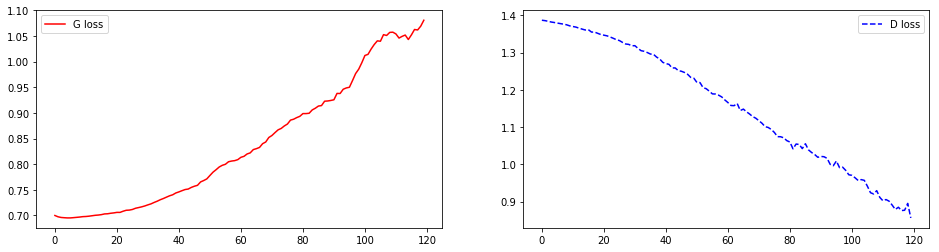

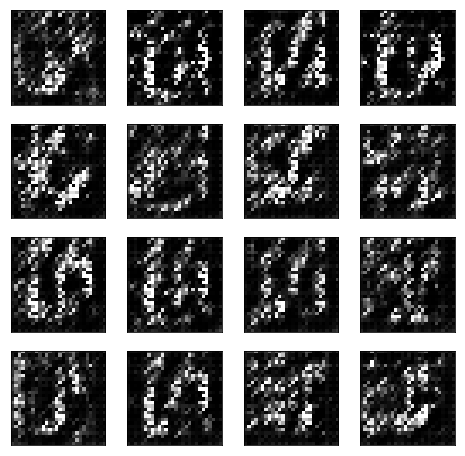

-------------------------------------------------------------------
[epoch 2], [training time 49.01]
-------------------------------------------------------------------


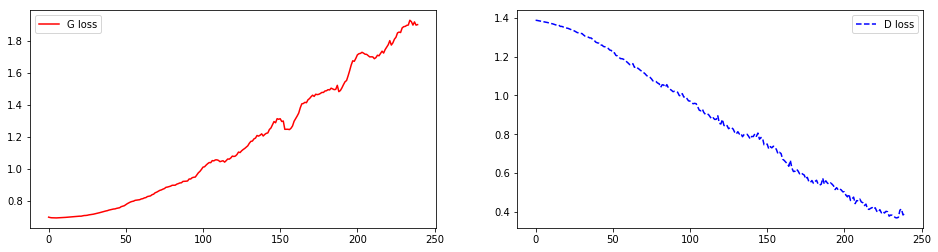

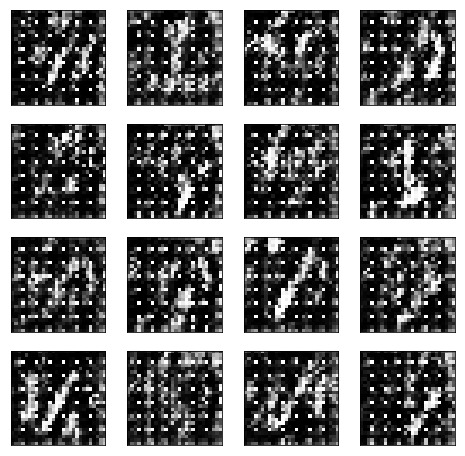

-------------------------------------------------------------------
[epoch 3], [training time 49.22]
-------------------------------------------------------------------


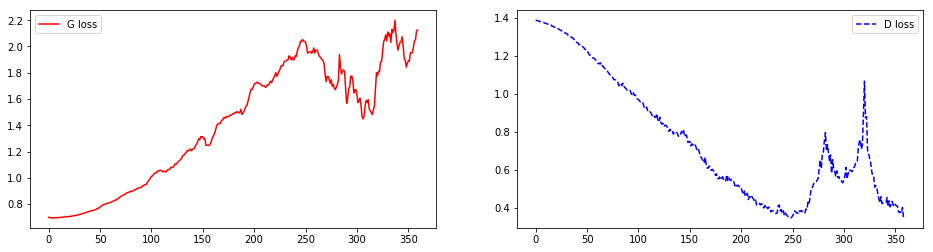

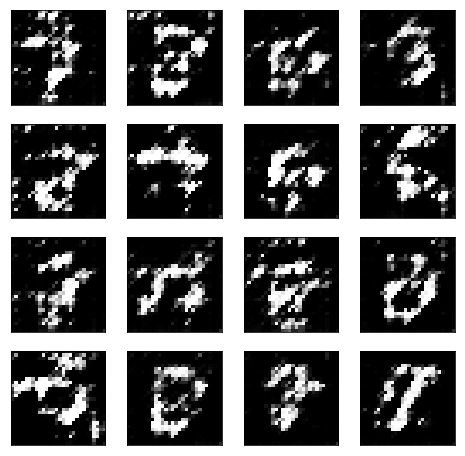

-------------------------------------------------------------------
[epoch 4], [training time 49.22]
-------------------------------------------------------------------


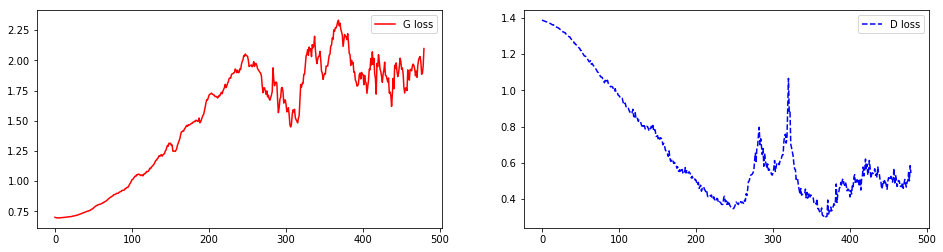

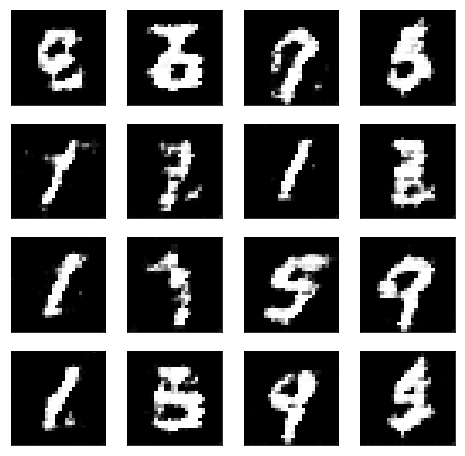

-------------------------------------------------------------------
[epoch 5], [training time 49.33]
-------------------------------------------------------------------


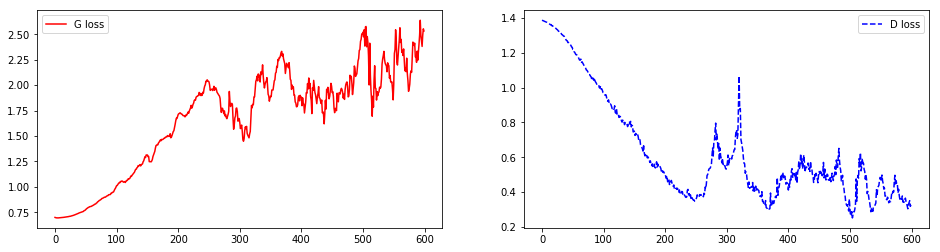

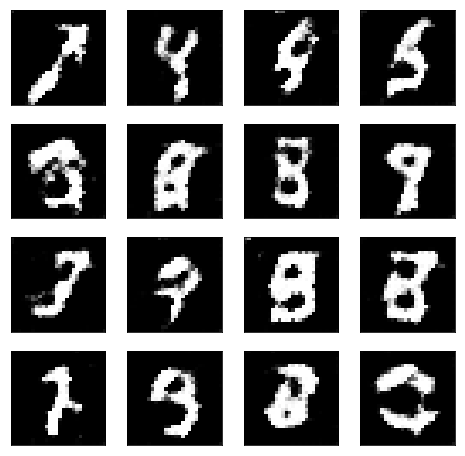

-------------------------------------------------------------------
[epoch 6], [training time 49.16]
-------------------------------------------------------------------


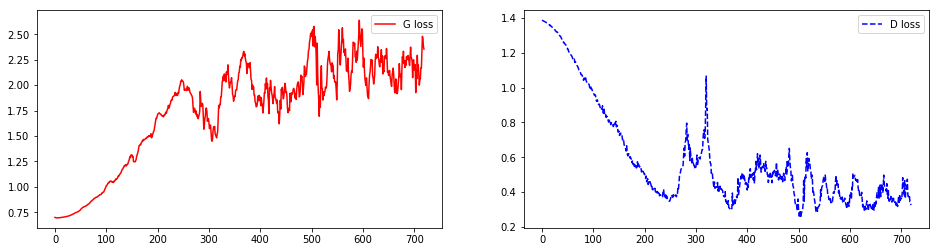

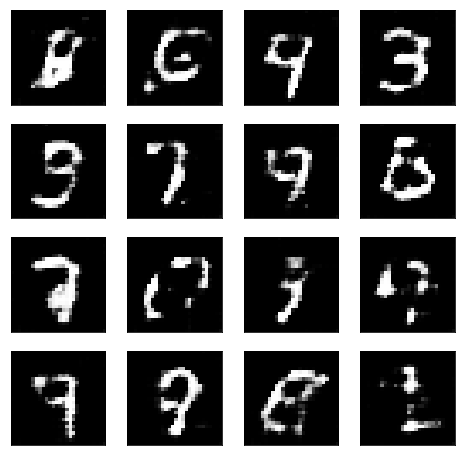

-------------------------------------------------------------------
[epoch 7], [training time 50.18]
-------------------------------------------------------------------


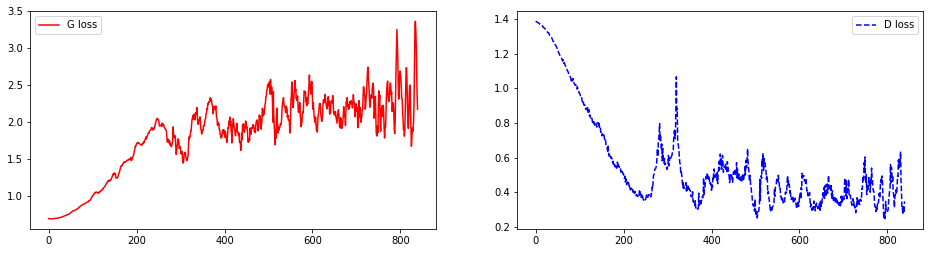

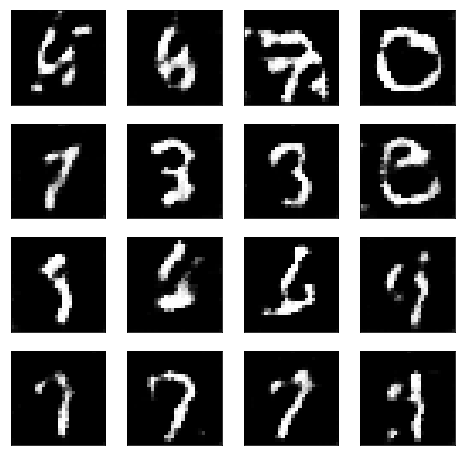

-------------------------------------------------------------------
[epoch 8], [training time 49.16]
-------------------------------------------------------------------


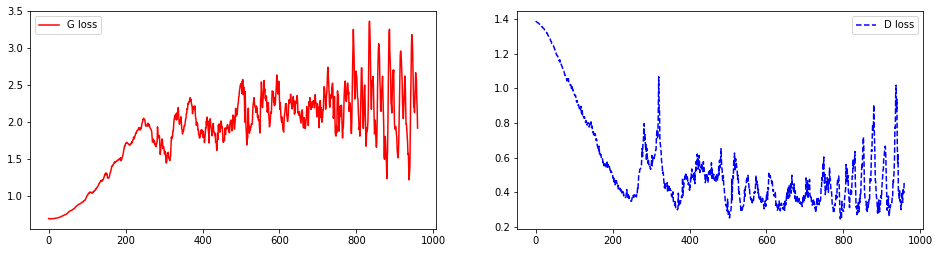

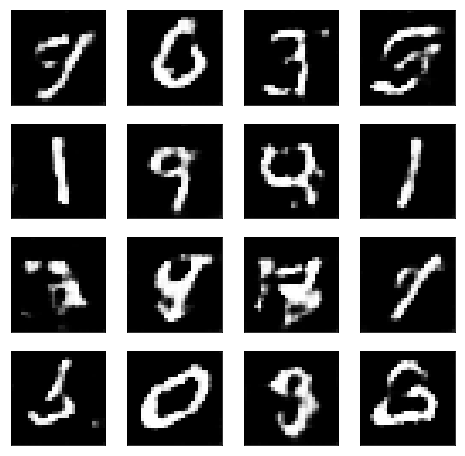

-------------------------------------------------------------------
[epoch 9], [training time 49.26]
-------------------------------------------------------------------


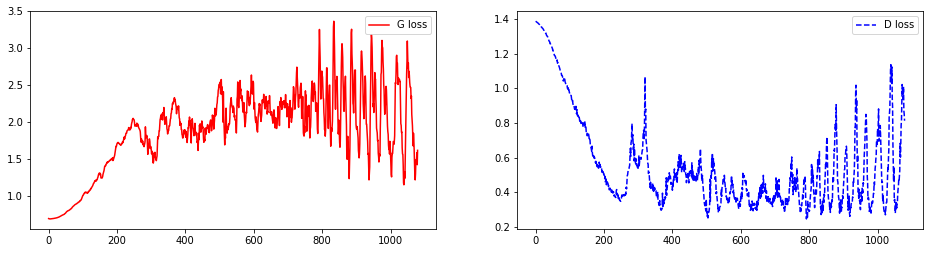

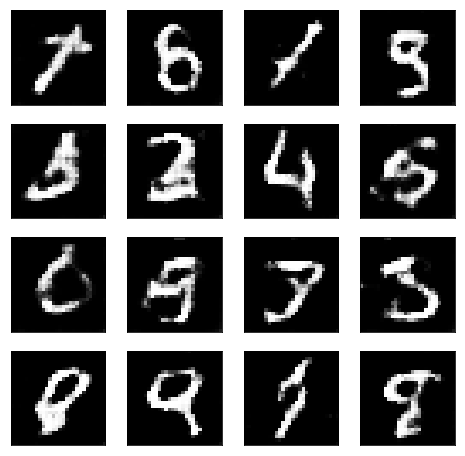

-------------------------------------------------------------------
[epoch 10], [training time 49.19]
-------------------------------------------------------------------


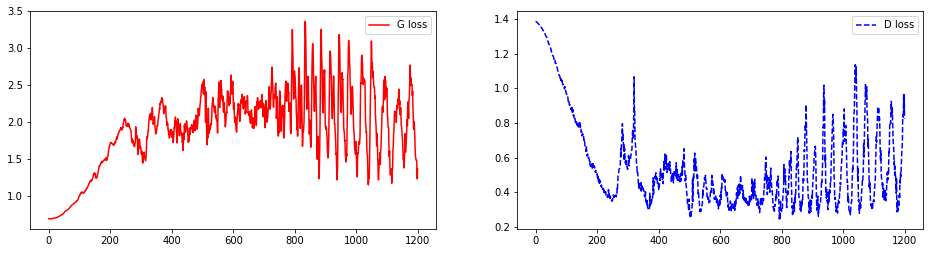

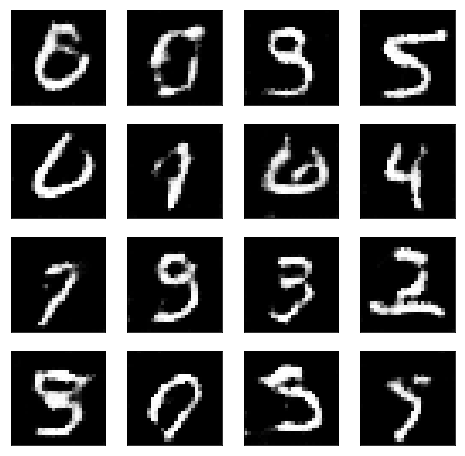

-------------------------------------------------------------------
[epoch 11], [training time 55.89]
-------------------------------------------------------------------


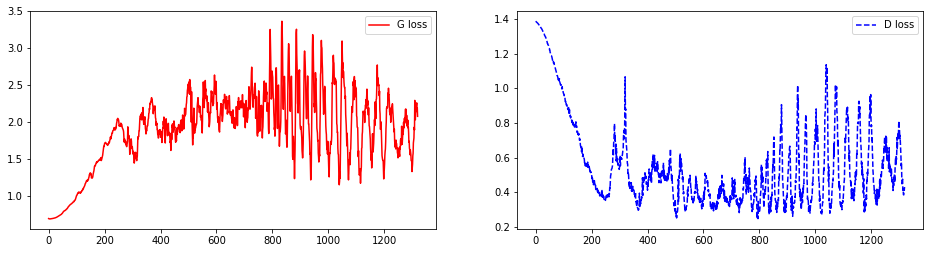

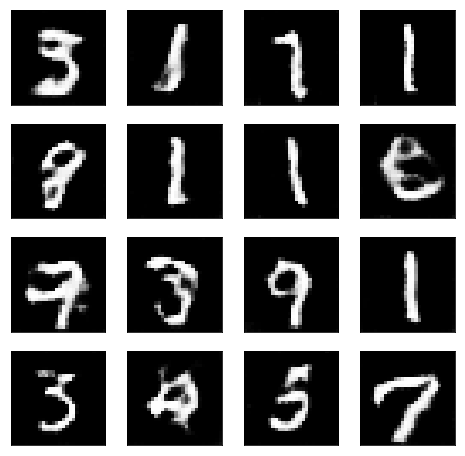

-------------------------------------------------------------------
[epoch 12], [training time 97.67]
-------------------------------------------------------------------


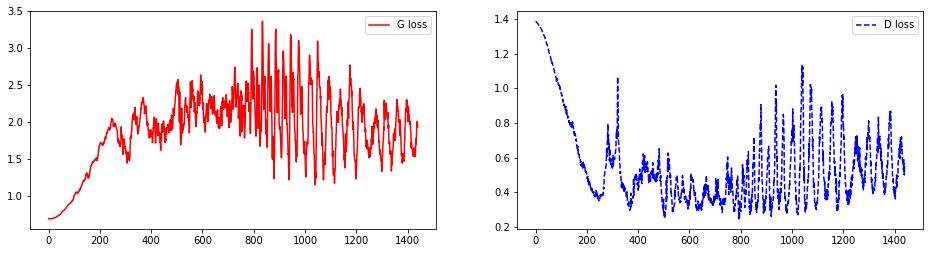

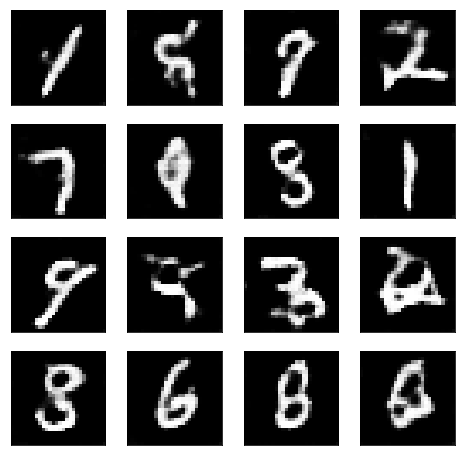

-------------------------------------------------------------------
[epoch 13], [training time 96.59]
-------------------------------------------------------------------


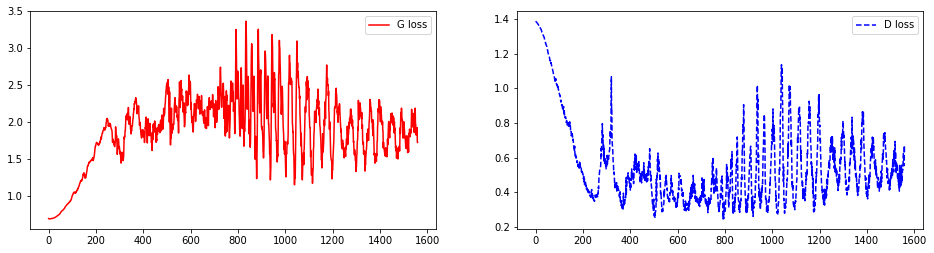

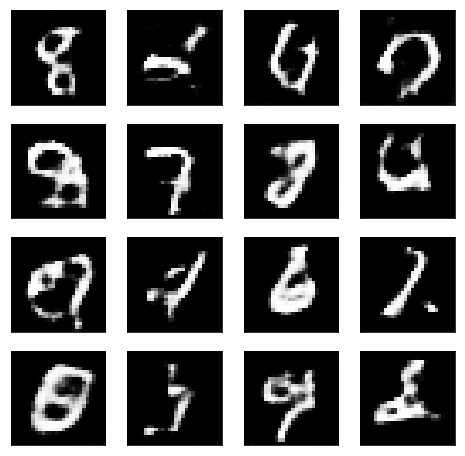

-------------------------------------------------------------------
[epoch 14], [training time 95.49]
-------------------------------------------------------------------


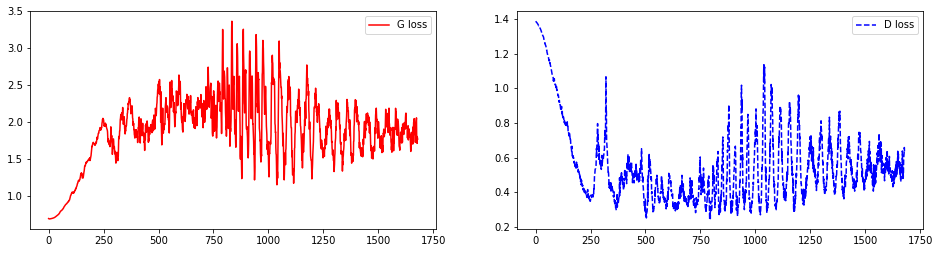

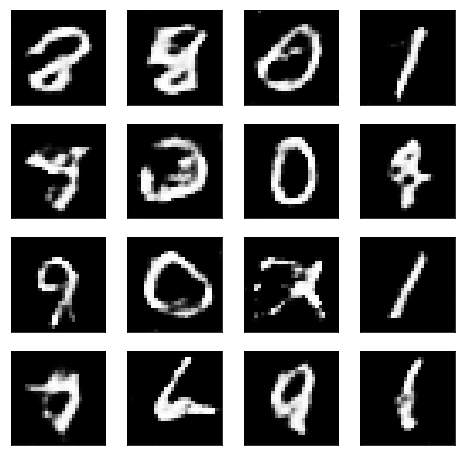

-------------------------------------------------------------------
[epoch 15], [training time 95.71]
-------------------------------------------------------------------


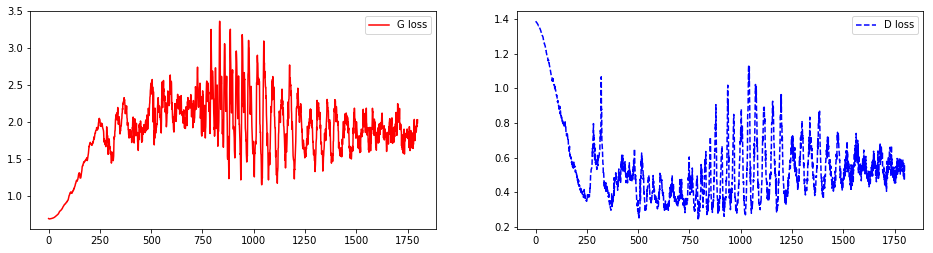

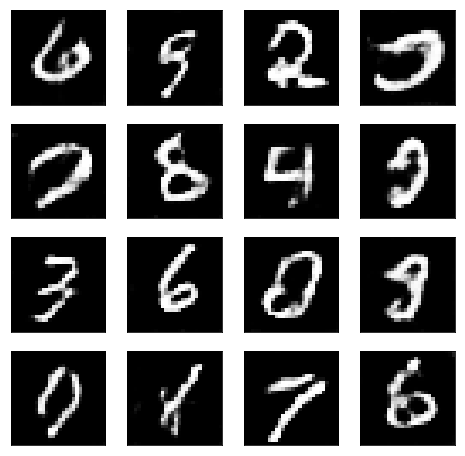

-------------------------------------------------------------------
[epoch 16], [training time 98.16]
-------------------------------------------------------------------


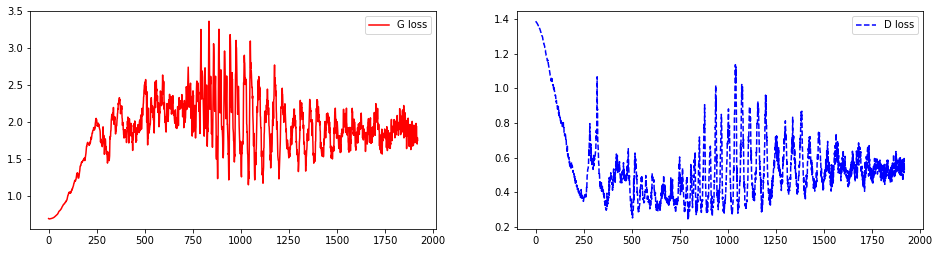

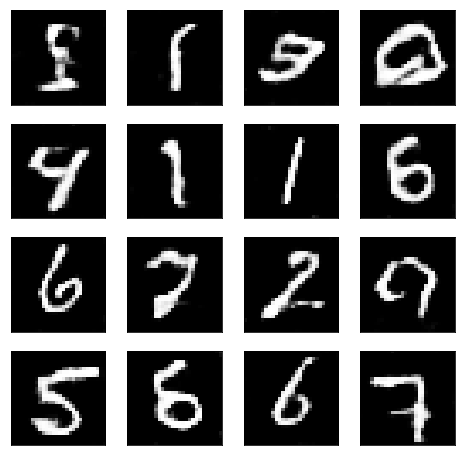

-------------------------------------------------------------------
[epoch 17], [training time 98.60]
-------------------------------------------------------------------


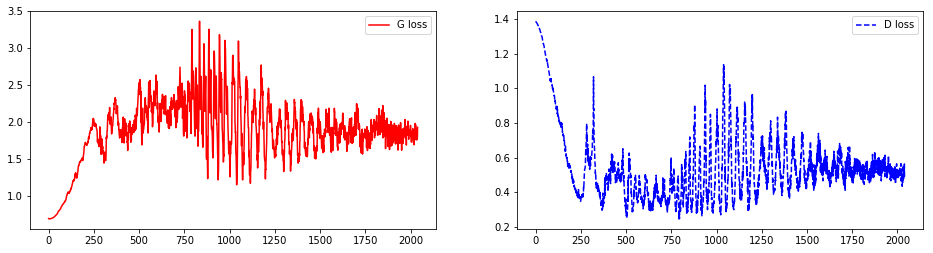

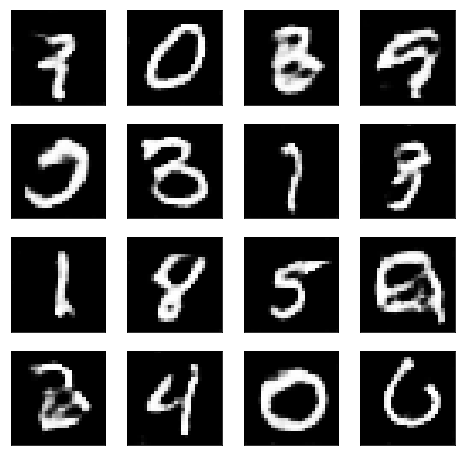

-------------------------------------------------------------------
[epoch 18], [training time 100.17]
-------------------------------------------------------------------


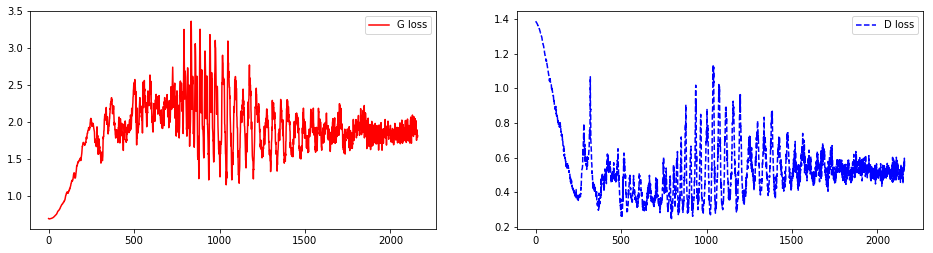

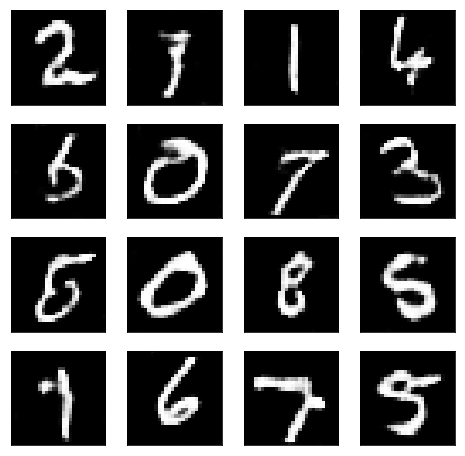

-------------------------------------------------------------------
[epoch 19], [training time 92.02]
-------------------------------------------------------------------


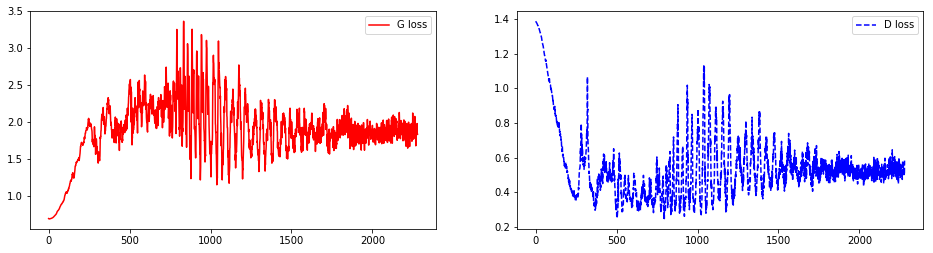

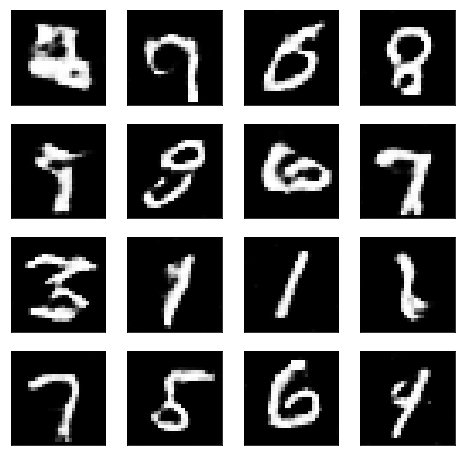

-------------------------------------------------------------------
[epoch 20], [training time 49.15]
-------------------------------------------------------------------


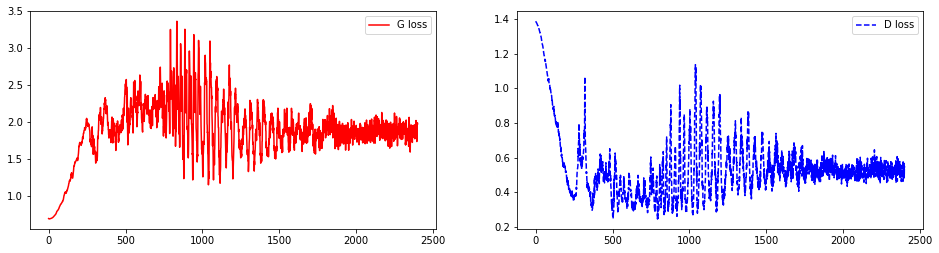

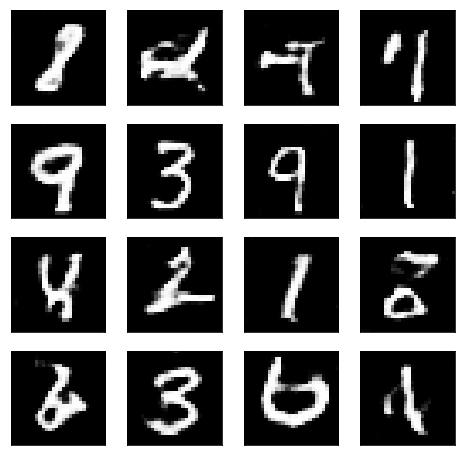

-------------------------------------------------------------------
[epoch 21], [training time 49.29]
-------------------------------------------------------------------


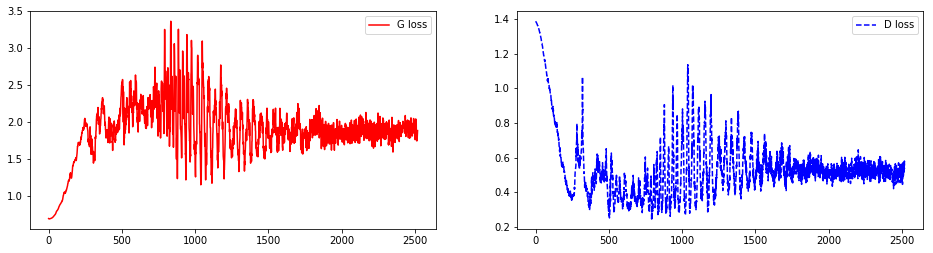

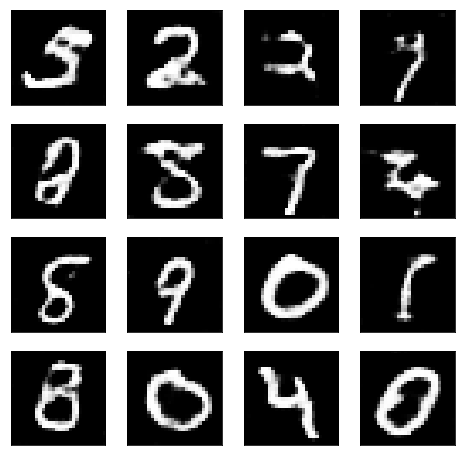

-------------------------------------------------------------------
[epoch 22], [training time 49.15]
-------------------------------------------------------------------


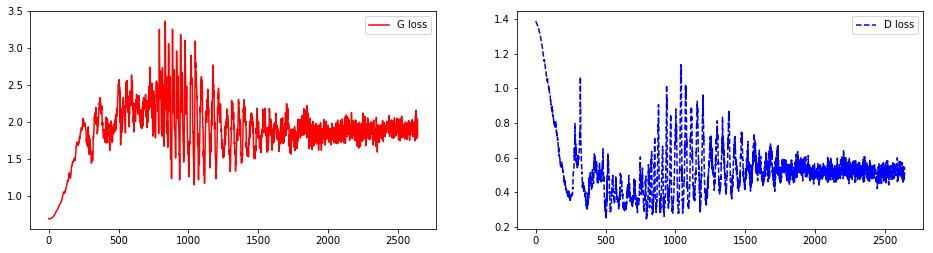

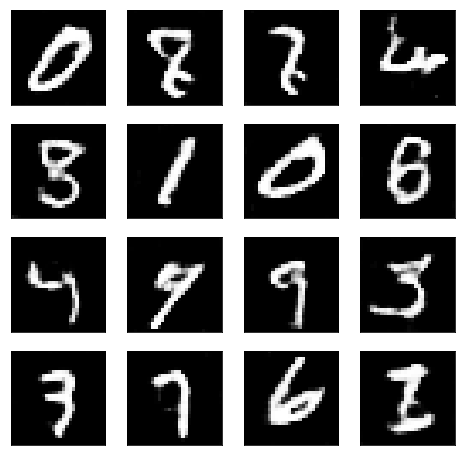

-------------------------------------------------------------------
[epoch 23], [training time 49.32]
-------------------------------------------------------------------


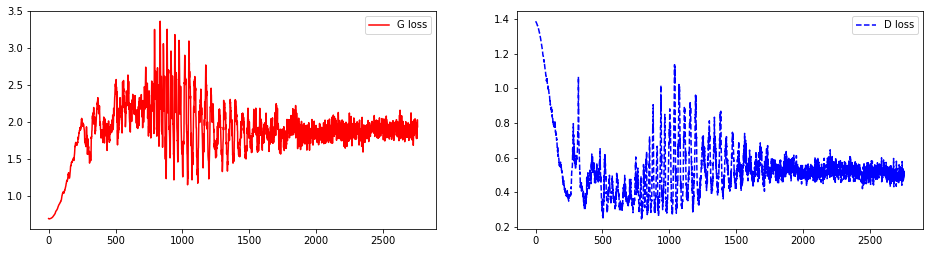

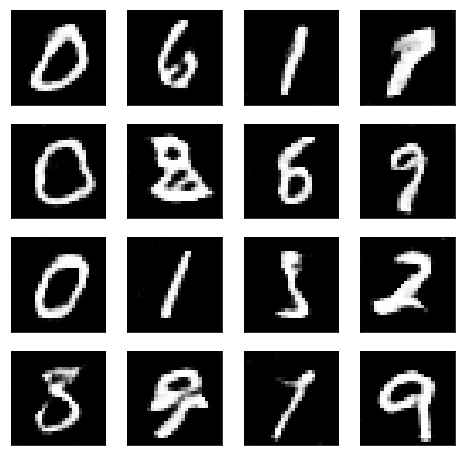

-------------------------------------------------------------------
[epoch 24], [training time 49.25]
-------------------------------------------------------------------


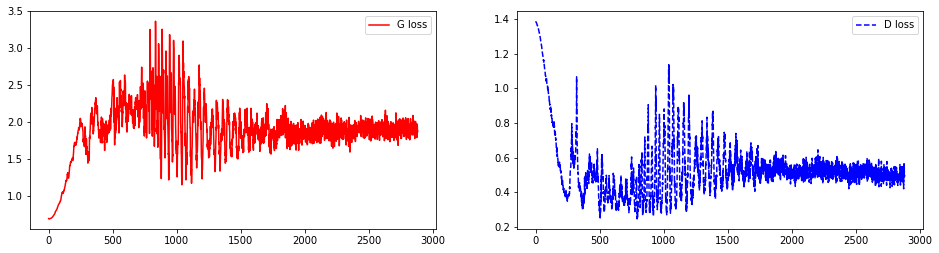

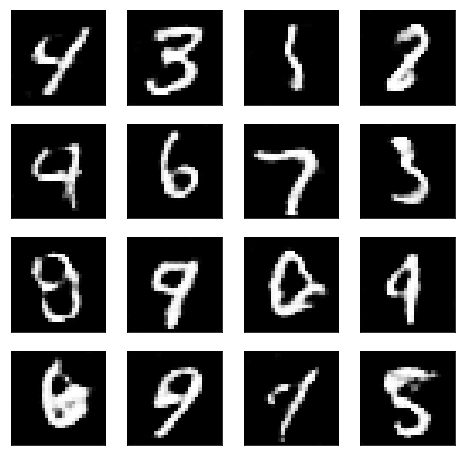

-------------------------------------------------------------------
[epoch 25], [training time 49.22]
-------------------------------------------------------------------


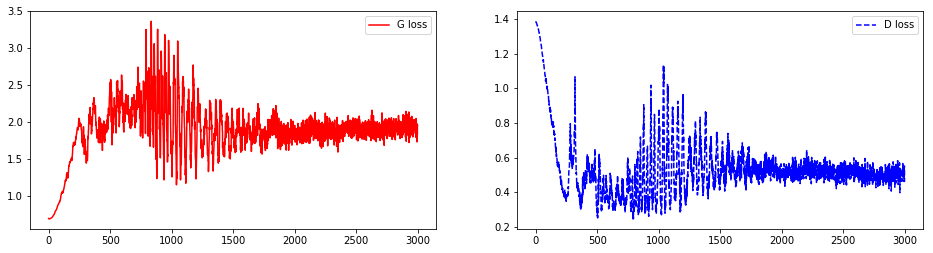

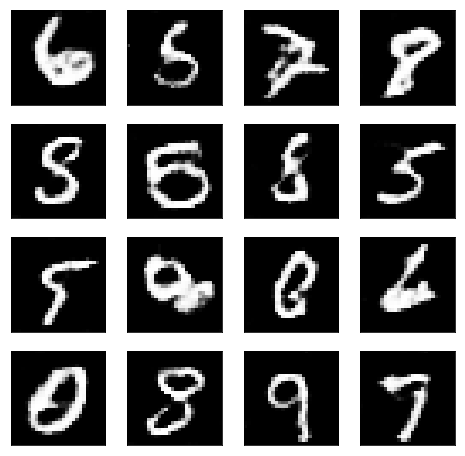

In [0]:
# Lists for losses.
train_loss_G = []
train_loss_D = []

# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train_loss_G, train_loss_D = train(train_loader,
                                       net_G, net_D,
                                       criterion,
                                       opt_G, opt_D,
                                       epoch,
                                       train_loss_G, train_loss_D)
    
    # Taking step on scheduler.
    scheduler_G.step()
    scheduler_D.step()

    if epoch % args['print_freq'] == 0:
        
        # Testing function for sample generation.
        evaluate(net_G, criterion, epoch)